In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import scipy

In [5]:
train = pd.read_csv("./data/multi/train_hydraulic.csv", sep=",")
test = pd.read_csv("./data/multi/test_hydraulic.csv", sep=",")

In [6]:
train.head()

,Unnamed: 0,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,...,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,Risk Level
0,0,T06,2016-01-01T00:00:00+00:00,1270.0,1232.8,1248.5,6.8,42.0,51,52,...,92.0,90.0,0.0,0.0,0.0,0.0,98.0,99.0,418.0,med-high
1,1,T06,2016-01-01T00:10:00+00:00,1429.7,203.9,1154.1,271.7,42.0,51,52,...,90.0,87.0,0.0,0.0,0.0,0.0,99.0,101.0,418.0,med-high
2,2,T06,2016-01-01T00:20:00+00:00,1360.5,250.3,1041.4,382.7,42.0,50,51,...,91.0,90.0,0.0,0.0,0.0,0.0,111.0,113.0,418.0,med-high
3,3,T06,2016-01-01T00:30:00+00:00,1399.2,1228.8,1252.5,16.5,42.0,49,50,...,90.0,90.0,0.0,0.0,0.0,0.0,122.0,125.0,418.0,med-high
4,4,T06,2016-01-01T00:40:00+00:00,1302.7,1225.1,1257.6,13.4,41.0,50,50,...,91.0,90.0,0.0,0.0,0.0,0.0,121.0,123.0,417.0,med-high


In [7]:
class_target_name = "Risk Level"
drop_cols = [class_target_name, "Turbine_ID", "Timestamp", "Unnamed: 0"]

In [8]:
print("\nTest unbalanced:\n")
print(test[class_target_name].value_counts())
print("\nTrain unbalanced:")
train[class_target_name].value_counts()


Test unbalanced:

low         134857
low-med       8477
medium        6839
med-high      4318
high          2940
Name: Risk Level, dtype: int64

Train unbalanced:


low         221500
medium       10406
high         10001
med-high      9316
low-med       8487
Name: Risk Level, dtype: int64

In [9]:
test_balanced = test.drop(test[test[class_target_name] == "low"].sample(n=126000).index)
train_balanced = train.drop(train[train[class_target_name] == "low"].sample(n=211000).index)

In [10]:
print("\nTest balanced:\n")
print(test_balanced[class_target_name].value_counts())
print("\nTrain balanced:")
train_balanced[class_target_name].value_counts()


Test balanced:

low         8857
low-med     8477
medium      6839
med-high    4318
high        2940
Name: Risk Level, dtype: int64

Train balanced:


low         10500
medium      10406
high        10001
med-high     9316
low-med      8487
Name: Risk Level, dtype: int64

In [11]:
test.isna().sum().sum()

511698

In [12]:
class FillMethod():

    def __init__(self, train: pd.DataFrame, test: pd.DataFrame, method: str) -> None:
        self.method = method
        if method == "median":
            self.train = train.fillna(train.median())
            self.test = test.fillna(test.median())
        else:
            self.train = self._handleValueError(train, method)
            self.test = self._handleValueError(test, method)

        self._downsample()

    def _downsample(self):
        self.test = self.test.drop(self.test[self.test[class_target_name] == "low"].sample(n=126000).index).dropna().sample(frac=1)
        self.train = self.train.drop(self.train[self.train[class_target_name] == "low"].sample(n=211000).index).dropna().sample(frac=1)

    def _handleValueError(self, in_data: pd.DataFrame, method: str) -> None:
        out_data = in_data.fillna(method=method)
        if out_data.isna().sum().sum():
            if method == "ffill":
                out_data = in_data.fillna(method="bfill")
            else: 
                out_data = in_data.fillna(method="ffill")
        if out_data.isna().sum().sum():
            out_data = in_data.fillna(in_data.median())

        return out_data

    def get_train_x(self) -> pd.DataFrame:
        return self.train.drop(columns=drop_cols)

    def get_train_y(self) -> pd.DataFrame:
        return self.train[class_target_name]

    def get_test_x(self) -> pd.DataFrame:
        return self.test.drop(columns=drop_cols)

    def get_test_y(self) -> pd.DataFrame:
        return self.test[class_target_name]

    def get_method(self) -> str:
        return self.method

In [13]:
fill_methods = ["median", "ffill", "bfill"]
fillers = []
for method in fill_methods:
    fillers.append(FillMethod(train, test, method))

In [14]:
# check if nan-values vanished
for filler in fillers:
    print(filler.train.shape)
    print(filler.test.shape)
    print(filler.train.isna().sum().sum())
    print(filler.test.isna().sum().sum())
    print(filler.get_method())

(48710, 108)
(31431, 108)
0
0
median
(48710, 108)
(31431, 108)
0
0
ffill
(48710, 108)
(31431, 108)
0
0
bfill


In [15]:
def train_run(X: pd.DataFrame, y: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, model: BaseEstimator) -> dict:

    clf = model
    clf.fit(X, y)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    scores = {
        "f1_train": f1_train,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

    return scores

In [16]:
# Utility function to report best scores
def report(results: dict, n_top=3) -> None:
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [17]:
def train_runs(fillers: list[FillMethod]) -> list[dict]:
    
    best_scores = []

    for filler in fillers:
        X_train = filler.get_train_x()
        X_test = filler.get_test_x()
        y_train = filler.get_train_y()
        y_test = filler.get_test_y()


        pipe = Pipeline([
            ('dt', DecisionTreeClassifier(random_state=0))
        ])

        param_grid = {
            "dt__max_depth": [30],
            "dt__min_samples_leaf": [1],
            "dt__class_weight": ["balanced"],
            "dt__criterion": ["log_loss"]
        }
        sh = GridSearchCV(pipe, param_grid, scoring="f1_weighted")
        fitted = sh.fit(X_train, y_train)
        clf = sh.best_estimator_
        report(sh.cv_results_)

        scores = train_run(X_train, y_train, X_test, y_test, model=clf)

        best_scores.append({
            "type": filler.get_method(),  "f1_train": scores["f1_train"], "f1": scores["f1"],
            "precision": scores["precision"], "recall": scores["recall"], "clf": clf})
    
    return best_scores

In [18]:
best_scores = train_runs(fillers)

Model with rank: 1
Mean validation score: 0.877 (std: 0.005)
Parameters: {'dt__class_weight': 'balanced', 'dt__criterion': 'log_loss', 'dt__max_depth': 30, 'dt__min_samples_leaf': 1}

Model with rank: 1
Mean validation score: 0.873 (std: 0.004)
Parameters: {'dt__class_weight': 'balanced', 'dt__criterion': 'log_loss', 'dt__max_depth': 30, 'dt__min_samples_leaf': 1}

Model with rank: 1
Mean validation score: 0.869 (std: 0.006)
Parameters: {'dt__class_weight': 'balanced', 'dt__criterion': 'log_loss', 'dt__max_depth': 30, 'dt__min_samples_leaf': 1}



In [19]:
best_scores

[{'type': 'median',
  'f1_train': 1.0,
  'f1': 0.1736812242951779,
  'precision': 0.21639975606654346,
  'recall': 0.24730361744774268,
  'clf': Pipeline(steps=[('dt',
                   DecisionTreeClassifier(class_weight='balanced',
                                          criterion='log_loss', max_depth=30,
                                          random_state=0))])},
 {'type': 'ffill',
  'f1_train': 0.9998562977866446,
  'f1': 0.16065590030449953,
  'precision': 0.19521353734986013,
  'recall': 0.22923228659603576,
  'clf': Pipeline(steps=[('dt',
                   DecisionTreeClassifier(class_weight='balanced',
                                          criterion='log_loss', max_depth=30,
                                          random_state=0))])},
 {'type': 'bfill',
  'f1_train': 0.9999794702768724,
  'f1': 0.15896917092108714,
  'precision': 0.1873262882041059,
  'recall': 0.2198784639368776,
  'clf': Pipeline(steps=[('dt',
                   DecisionTreeClassifier(class_weig

In [20]:
y_pred = best_scores[0]["clf"].predict(fillers[0].get_test_x())

(array([22658.,  4283.,  1581.,  1676.,  1233.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

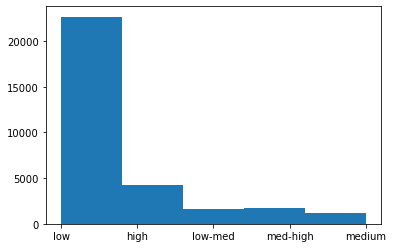

In [23]:
plt.hist(y_pred, bins=5)

(array([8477., 6839., 8857., 4318., 2940.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

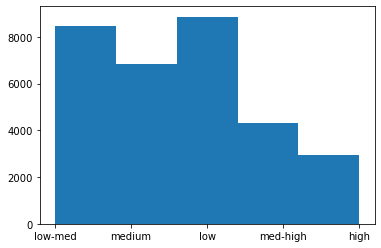

In [24]:
plt.hist(fillers[0].get_test_y(), bins=5)

In [87]:
import os
os.makedirs("./data/data_prepared", exist_ok=True)

In [88]:
fillers[0].train.to_csv("./data/data_prepared/train_hydraulic_multi.csv")
fillers[0].test.to_csv("./data/data_prepared/test_hydraulic_multi.csv")